In [1]:
import os
# from glob import glob
# from IPython.display import Image
from skimage import io, transform
# from PIL import Image
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
# import tensorflow as tf
# print(tf.__version__)
import time 
import random
import copy
import pickle

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
import torch.nn as nn 
from torch.optim import Adam#, SGD, Adagrad, Adadelta, AdamW, SparseAdam, Adamax, ASGD, RMSprop, Rprop

In [3]:
#test to see if pytorch can be run on GPU
torch.cuda.is_available()

True

In [4]:
# define a seed for reproducibility
seed = 5436457
torch.manual_seed(seed)

## Map coordinates

In [5]:
##Read train csv file
trainDF = pd.read_csv("./data/piom_train_30k.csv")
trainDF.drop(columns=["Unnamed: 0"],inplace=True)
# print(trainDF.head())

## Transform coordinates in geographic zone

In [6]:
# #continental zones
# def classify_geographic_zones(row):
# #     print(type(row['llcrnrlon']))
#     if row['llcrnrlon']<-100. and row['llcrnrlat']>10.:
#         return(0) #AmNW
#     elif row['llcrnrlon']<-30. and row['llcrnrlat']>10.:
#         return(1) #AmNE
#     elif row['llcrnrlon']<-30. and row['llcrnrlat']<=0.:
#         return(2) #AmS
#     elif row['llcrnrlon']<60. and row['llcrnrlat']>35.:
#         return(3) #Eu
#     elif row['llcrnrlon']<60. and row['llcrnrlat']<=35.:
#         return(4) #Af
#     elif row['llcrnrlat']>0.:
#         return(5) #As
#     else:
#         return(6) #Oc

In [7]:
#more precised zones
def classify_geographic_zones(row):
#     print(type(row['llcrnrlon']))
    if row['llcrnrlon']<-100. and row['llcrnrlat']>30.:
        return(0) #AmNW
    elif row['llcrnrlon']<-30. and row['llcrnrlat']>30.:
        return(1) #AmNE
    elif row['llcrnrlon']<-30. and row['llcrnrlat']>0.:
        return(2) #AmC
    elif row['llcrnrlon']<-30. and row['llcrnrlat']<=0.:
        return(3) #AmS
    elif row['llcrnrlon']<90. and row['llcrnrlat']>45.:
        return(4) #EuN
    elif row['llcrnrlon']<60. and row['llcrnrlat']>20.:
        return(5) #Med
    elif row['llcrnrlon']<60. and row['llcrnrlat']<=20.:
        return(6) #Af
    elif row['llcrnrlat']>35.:
        return(7) #AsE
    elif row['llcrnrlat']>5.:
        return(8) #AsS
    elif row['llcrnrlat']>-20.:
        return(9) #Ind
    else:
        return(10) #Aus

In [8]:
trainDF['Geo_zone'] = trainDF.apply(classify_geographic_zones, axis=1)

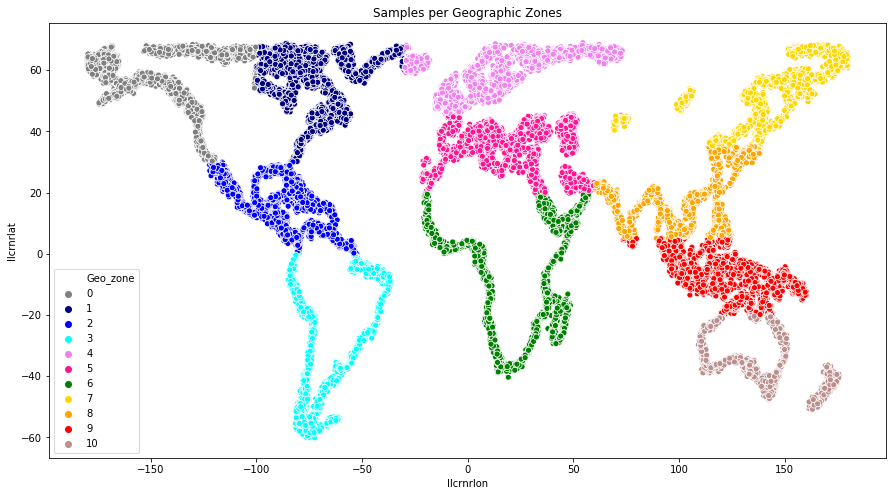

In [9]:
colors = ['grey', 'navy', 'blue', 'cyan', 'violet', 'deeppink', 'green', 'gold', 'orange', 'red', 'rosybrown']
plt.figure(figsize = (15,8))
sns.scatterplot(trainDF['llcrnrlon'], trainDF['llcrnrlat'], hue=trainDF['Geo_zone'], palette=colors)
plt.title('Samples per Geographic Zones')
plt.show()

In [10]:
##Visualizing distribution of the geographic zones
# plt.figure(figsize=(8, 4))
# trainDF['Geo_zone'].value_counts().plot(kind='bar')
# plt.ylabel('Count')
# plt.xlabel('Label')
# plt.title('Sample distribution per Geographic Zones')
# plt.show()
# print(trainDF['Geo_zone'].value_counts())

## Build a custom dataloader for training data

In [11]:
class MapDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, coordinateDf, root_dir, transform=None):
        """
        Args:
            coordinateDf (pd.DataFrame): DataFrame with image id and geographic coordinates.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.map_coordinates = coordinateDf
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.map_coordinates)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir,
                                self.map_coordinates.iloc[idx, 0] + '.png')
#         startTime = time.time()
#         image = io.imread(img_name)
#         image = Image.open(img_name)
        image = cv.imread(img_name)
#         print("Image reading time: ", time.time()-startTime)  
#         startTrainingTime = time.time()
#         image = transform.resize(image, (62, 62), mode='reflect', anti_aliasing=True)
#         print("Image resizing time: ", time.time()-startTime) 
        
#         startTime = time.time()
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        ret,thresh_img = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)
        kernel = cv.getStructuringElement(cv.MORPH_RECT, (4,8))
        morph_img = cv.morphologyEx(thresh_img, cv.MORPH_CLOSE, kernel)
#         print("Image grayscale time: ", time.time()-startTime) 
        
        coordinates_llcrnr = np.array([self.map_coordinates['llcrnrlon'].iloc[idx], 
                               self.map_coordinates['llcrnrlat'].iloc[idx]]).astype('float') #.reshape(-1, 2)
        coordinates_urcrnr = np.array([self.map_coordinates['urcrnrlon'].iloc[idx], 
                               self.map_coordinates['urcrnrlat'].iloc[idx]]).astype('float')
        coordinates_center = np.array([(self.map_coordinates['llcrnrlon'].iloc[idx] + 
                                       self.map_coordinates['urcrnrlon'].iloc[idx])//2,
                                       (self.map_coordinates['llcrnrlat'].iloc[idx] + 
                                       self.map_coordinates['urcrnrlat'].iloc[idx])//2]).astype('float')
        
        sample = {'image': image, 'coordinates_center': coordinates_center,
                  'coordinates_llcrnr': coordinates_llcrnr, 'coordinates_urcrnr': coordinates_urcrnr,
                  'Geo_zone': self.map_coordinates['Geo_zone'].iloc[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [12]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image, (new_h, new_w), mode='reflect', anti_aliasing=True)

        return {'image': image, 
                'coordinates_center': sample['coordinates_center'],
                'coordinates_llcrnr': sample['coordinates_llcrnr'], 
                'coordinates_urcrnr': sample['coordinates_urcrnr'],
                'Geo_zone': sample['Geo_zone']}

class SquareRescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        
#         print('image : ', image)
        image = cv.resize(image, (self.output_size, self.output_size))
#         image = transform.resize(image, (self.output_size, self.output_size), mode='reflect', anti_aliasing=True)

        return {'image': image, 
                'coordinates_center': sample['coordinates_center'],
                'coordinates_llcrnr': sample['coordinates_llcrnr'], 
                'coordinates_urcrnr': sample['coordinates_urcrnr'],
                'Geo_zone': sample['Geo_zone'] }


class CenterCrop(object):
    """Crop the image in a sample centered to the middle of the image.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        image = image[((h - new_h)//2): ((h - new_h)//2) + new_h,
                      ((w - new_w)//2): ((w - new_w)//2) + new_w]

        return {'image': image, 
                'coordinates_center': sample['coordinates_center'],
                'coordinates_llcrnr': sample['coordinates_llcrnr'], 
                'coordinates_urcrnr': sample['coordinates_urcrnr'],
                'Geo_zone': sample['Geo_zone'] }


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, image.shape[0], image.shape[0])
        return {'image': torch.from_numpy(image), 
                'coordinates_center': torch.from_numpy(sample['coordinates_center']),
                'coordinates_llcrnr': torch.from_numpy(sample['coordinates_llcrnr']), 
                'coordinates_urcrnr': torch.from_numpy(sample['coordinates_urcrnr']),
                'Geo_zone': sample['Geo_zone']}

In [13]:
# Helper function to show and localise a batch
def show_batch(sample_batched):
    """Show images and coordinates on word map for a batch of samples."""
    images_batch, coordinates_center_batch, coordinates_llcrnr_batch, coordinates_urcrnr_batch = \
            sample_batched['image'], sample_batched['coordinates_center'], \
            sample_batched['coordinates_llcrnr'], sample_batched['coordinates_urcrnr']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch) #utils.make_grid(images_batch[:,:3,:,:])
    plt.figure(figsize=(30,10))
    plt.imshow(grid.numpy().transpose((1, 2, 0)), cmap='gray', vmin=0, vmax=255) #.transpose((1, 2, 0)))
#     print(coordinates_llcrnr_batch)
#     plt.axis('off')
#     plt.ioff()
    plt.title('Batch from dataloader')
    plt.figure(figsize=(15,5))
    plt.scatter(trainDF['llcrnrlon'], trainDF['llcrnrlat'], c='blue', marker='.')
    plt.scatter([float(coordlon[0]) for coordlon in(coordinates_center_batch)], 
                [float(coordlat[1]) for coordlat in(coordinates_center_batch)], c='red', marker='x')
    plt.scatter([float(coordlon[0]) for coordlon in(coordinates_llcrnr_batch)], 
                [float(coordlat[1]) for coordlat in(coordinates_llcrnr_batch)], c='green', marker='o')
    plt.scatter([float(coordlon[0]) for coordlon in(coordinates_urcrnr_batch)], 
                [float(coordlat[1]) for coordlat in(coordinates_urcrnr_batch)], c='green', marker='*')
    plt.title('Image localization')

In [14]:
batch_size = 50
train_map_data = MapDataset(trainDF, './data/piom_train_png_30k/', transform= transforms.Compose([
                                               SquareRescale(62),
                                               CenterCrop((61,61)),
#                                                transforms.CenterCrop([124,124]),
#                                                transforms.ToTensor(),
                                               ToTensor(),
                                           ]))

train_loader = torch.utils.data.DataLoader(train_map_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=8)

In [15]:
# for i_batch, sample_batch in enumerate(train_loader):
# #     break
# #     print(i_batch, sample_batch['image'].size())
# #     plt.imshow(sample_batch['image'][0], cmap='gray', vmin=0, vmax=255)
# #     plt.show()
#     if i_batch == 0:
#         plt.figure()
#         show_batch(sample_batch)
#         plt.show()
#         break

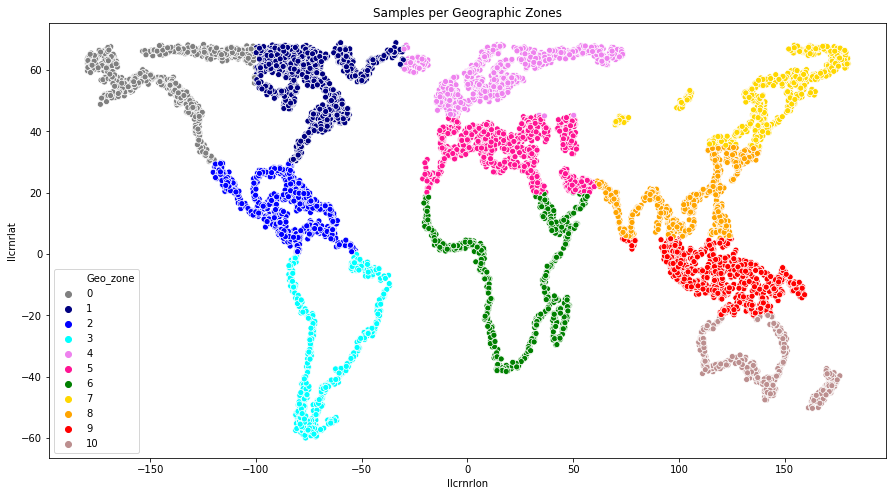

In [16]:
##Read validation csv file
valDF = pd.read_csv("./data/piom_train2_10k.csv")
valDF.drop(columns=["Unnamed: 0"],inplace=True)
valDF['Geo_zone'] = valDF.apply(classify_geographic_zones, axis=1)
plt.figure(figsize = (15,8))
sns.scatterplot(valDF['llcrnrlon'], valDF['llcrnrlat'], hue=valDF['Geo_zone'], palette=colors)
plt.title('Samples per Geographic Zones')
plt.show()

In [17]:
#validation set dataloader
val_batch_size = 500
validation_map_data = MapDataset(valDF, './data/piom_train2_png_10k/', transform= transforms.Compose([
                                               SquareRescale(62),
                                               CenterCrop((61,61)),
                                               ToTensor(),
                                           ]))

validation_loader = torch.utils.data.DataLoader(validation_map_data,
                                          batch_size=val_batch_size,
                                          shuffle=False,
                                          num_workers=8,
                                          drop_last=False)

## CNN to predict coordinates

In [18]:
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    return(output)

In [19]:
class SimpleCNN(nn.Module):   
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.BatchNorm2d(num_features=nfeatures),
            nn.Conv2d(in_channels=nfeatures, out_channels=conv1[0], kernel_size=conv1[1], stride=conv1[2], padding=conv1[3]),
            nn.BatchNorm2d(num_features=conv1[0]),
            #ReLU(inplace=True),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=max1[0], stride=max1[1], padding=max1[2]),
            nn.Conv2d(in_channels=conv1[0], out_channels=conv2[0], kernel_size=conv2[1], stride=conv2[2], padding=conv2[3]),
            nn.BatchNorm2d(num_features=conv2[0]),
            #ReLU(inplace=True),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=max2[0], stride=max2[1], padding=max2[2]),
            nn.Conv2d(in_channels=conv2[0], out_channels=conv3[0], kernel_size=conv3[1], stride=conv3[2], padding=conv3[3]),
            nn.BatchNorm2d(num_features=conv3[0]),
            #ReLU(inplace=True),
            nn.PReLU(),
        )
        self.drop_out = nn.Dropout(p=0.1)
        ft_length=outputSize(
                        outputSize(
                            outputSize(
                                outputSize(
                                    outputSize(init_ft_length, conv1[1], conv1[2], conv1[3]), 
                                    max1[0], max1[1], max2[2]),
                                conv2[1], conv2[2], conv2[3]),
                            max2[0], max2[1], max2[2]),
                        conv3[1], conv3[2], conv3[3])
        self.linear_layers = nn.Sequential(
            nn.Linear((conv3[0]*ft_length*ft_length), (conv3[0]*ft_length*ft_length)//2),
            nn.Linear((conv3[0]*ft_length*ft_length)//2, 11)
        )
        
        self.softmax = nn.LogSoftmax(dim=1)

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear_layers(x)
        x = self.softmax(x)
        return x

In [20]:
#CNN parameters Simple1DCNN
init_ft_length=61
nfeatures=1
conv1 = [8, 5, 1, 2]
max1 = [2, 2, 1]
conv2 = [8, 3, 1, 1]
max2 = [2, 2, 1]
conv3 = [8, 3, 1, 1]
print('Training batch size: ',batch_size)

Training batch size:  50


In [21]:
# custom loss function
class Interval_Loss(torch.nn.Module):
    
    def __init__(self):
        super(Interval_Loss,self).__init__()
        
#     def forward(self,x,y):
#         y_shape = y.size()[1]
#         x_added_dim = x.unsqueeze(1)
#         x_stacked_along_dimension1 = x_added_dim.repeat(1,NUM_WORDS,1)
#         diff = torch.sum((y - x_stacked_along_dimension1)**2,2)
#         totloss = torch.sum(torch.sum(torch.sum(diff)))
#         return totloss
    def forward(self, output, target):
        if torch.mean((output - target)**2) < 2500:
            return (torch.mean((output - target)**2))
        else:
            return (torch.mean((output - target)**2)+10000)

In [22]:
# defining the model
model = SimpleCNN()

# defining the optimizer
optimizer = Adam(model.parameters())
# optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)

# defining the loss function
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
# criterion = NLLLoss()
# criterion = Interval_Loss()

# model on GPU if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.float()
model = model.to(device)
criterion = criterion.to(device)

print(model)

SimpleCNN(
  (cnn_layers): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): PReLU(num_parameters=1)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): PReLU(num_parameters=1)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): PReLU(num_parameters=1)
  )
  (drop_out): Dropout(p=0.1, inplace=False)
  (linear_layers): Sequential(
    (0): Linear(in_features=2048, out_feat

In [23]:
# Train the model
startTrainingTime = time.time()
n_epochs = 1
verbose = True
total_step = len(train_loader)
loss_list = []
accuracy_list = []
compute_validation = True
val_accuracy_list = []
for epoch in range(n_epochs):
    for i_batch, sample_batch in enumerate(train_loader):
        # Run the forward pass
        train_X = sample_batch['image'].float().to(device)
        train_Y = sample_batch['Geo_zone'].long().to(device)
        outputs = model(train_X)
        loss = criterion(outputs, train_Y)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
#         predicted = outputs.data
        softmax = torch.exp(outputs).cpu()
        prob = list(softmax.detach().numpy())
        predicted = np.argmax(prob, axis=1)
        accuracy = accuracy_score(predicted,
                                   train_Y.detach().cpu())
        accuracy_list.append(accuracy)
        
        if verbose:
            if (i_batch + 1) % 50 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, n_epochs, i_batch + 1, total_step, loss.item(), accuracy))
    if compute_validation:
        val_predicted = []
        val_true = []
        total_step = len(validation_loader)
        for i_batch, sample_batch in enumerate(validation_loader):
            # prediction for validation set
            with torch.no_grad():
                val_X = sample_batch['image'].float().to(device)
                val_true.extend(sample_batch['Geo_zone'].long().detach().cpu())
                outputs = model(val_X)
                softmax = torch.exp(outputs).cpu()
                prob = list(softmax.detach().numpy())
                predicted = np.argmax(prob, axis=1)
                val_predicted.extend(predicted)
        val_accuracy = accuracy_score(val_predicted, torch.stack(val_true))
        val_accuracy_list.append(val_accuracy)
        print('Validation accuracy: {}'.format(val_accuracy)) 

print("Training time: ", time.time()-startTrainingTime) 

BrokenPipeError: [Errno 32] Broken pipe

In [23]:
# # plotting the training loss
# plt.plot(loss_list, label='Training loss')
# plt.legend()
# plt.show()

In [24]:
# # plotting the training loss
# plt.plot(val_accuracy_list, label='Validation accuracy')
# plt.legend()
# plt.show()

## Result on trainning set

In [25]:
# batch_size = 500

# train_loader_2 = torch.utils.data.DataLoader(train_map_data,
#                                               batch_size=batch_size,
#                                               shuffle=False,
#                                               num_workers=0)

In [26]:
# train_predicted = []
# train_true = []
# total_step = len(train_loader_2)
# for i_batch, sample_batch in enumerate(train_loader_2):
#     # prediction for validation set
#     with torch.no_grad():
#         train_X = sample_batch['image'].float().to(device)
#         train_true.extend(sample_batch['Geo_zone'].long().detach().cpu())
#         outputs = model(train_X)
#         softmax = torch.exp(outputs).cpu()
#         prob = list(softmax.detach().numpy())
#         predicted = np.argmax(prob, axis=1)
#         train_predicted.extend(predicted)
#     print('batch {}/{}, accuracy:{}'
#           .format(i_batch + 1, total_step, 
#                   accuracy_score(predicted, sample_batch['Geo_zone'].float().detach().cpu())))
# train_accuracy = accuracy_score(train_predicted, torch.stack(train_true))
# print('Training accuracy: {}'.format(train_accuracy)) 

In [27]:
#dropout0.1, 15epochs: Training accuracy: 0.6655333333333333
#dropoutNan, 5epochs: Training accuracy: 0.5505666666666666
#dropout0.5, 7epochs: Training accuracy: 0.5158

#11 classes
#dropout0.1, 5epochs: Training accuracy: 0.5723666666666667
#dropout0.1, 7epochs: Training accuracy: 0.6114333333333334
#dropout0.1, 28epochs: Training accuracy: 0.6992333333333334
#dropout0.1, 29epochs: Training accuracy: 0.6908

In [28]:
# #training set and plot prediction
# plt.figure(figsize = (15,8))
# sns.scatterplot(trainDF['llcrnrlon'], trainDF['llcrnrlat'], hue=train_predicted, palette=colors)
# plt.title('Training set - Geographic zone prediction')
# plt.savefig('./outputs/training_localisation_geo_zone.png')
# plt.show()

In [29]:
# def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
#     """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
#     Arguments
#     ---------
#     confusion_matrix: numpy.ndarray
#         The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
#         Similarly constructed ndarrays can also be used.
#     class_names: list
#         An ordered list of class names, in the order they index the given confusion matrix.
#     figsize: tuple
#         A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
#         the second determining the vertical size. Defaults to (10,7).
#     fontsize: int
#         Font size for axes labels. Defaults to 14.
        
#     Returns
#     -------
#     matplotlib.figure.Figure
#         The resulting confusion matrix figure
#     """
#     df_cm = pd.DataFrame(
#         confusion_matrix, index=class_names, columns=class_names, 
#     )
#     fig = plt.figure(figsize=figsize)
#     try:
#         heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
#     except ValueError:
#         raise ValueError("Confusion matrix values must be integers.")
#     heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
#     heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     return

In [30]:
# print_confusion_matrix(confusion_matrix(torch.stack(train_true), train_predicted), class_names=range(0,11))

## Result on validation set

In [31]:
# startTime = time.time()
# val_predicted = []
# val_true = []
# total_step = len(validation_loader)
# for i_batch, sample_batch in enumerate(validation_loader):
#     # prediction for validation set
#     with torch.no_grad():
#         val_X = sample_batch['image'].float().to(device)
#         val_true.extend(sample_batch['Geo_zone'].long().detach().cpu())
#         outputs = model(val_X)
#         softmax = torch.exp(outputs).cpu()
#         prob = list(softmax.detach().numpy())
#         predicted = np.argmax(prob, axis=1)
#         val_predicted.extend(predicted)
#     print('batch {}/{}, accuracy:{}'
#           .format(i_batch + 1, total_step, 
#                   accuracy_score(predicted, sample_batch['Geo_zone'].float().detach().cpu())))
# val_accuracy = accuracy_score(val_predicted, torch.stack(val_true))
# print('Validation accuracy: {}'.format(val_accuracy)) 
# print("Validation time: ", time.time()-startTime) 

In [32]:
#dropoutNan, 5epochs: Validation accuracy: 0.4865
#dropout0.5, 7epochs: Validation accuracy: 0.4879

#11 classes
#dropout0.1, 5epochs: Validation accuracy: 0.4963
#dropout0.1, 7epochs: Validation accuracy: 0.5039
#dropout0.1, 28epochs: Validation accuracy: 0.5288
#dropout0.1, 28epochs: Validation accuracy: 0.5276

In [33]:
# #training set and plot prediction
# npoints = 20
# plt.figure(figsize = (15,8))
# sns.scatterplot(valDF['llcrnrlon'], valDF['llcrnrlat'], hue=val_predicted, palette=colors)
# plt.title('Validation set - Geographic zone prediction')
# plt.savefig('./outputs/validation_localisation_geo_zone.png')
# plt.show()

In [34]:
# print_confusion_matrix(confusion_matrix(torch.stack(val_true), val_predicted), class_names=range(0,11))

In [35]:
# # save model in pth file
# MODEL_PATH = './models/gpu_model.pth'
# torch.save(model.state_dict(), MODEL_PATH)

# # copy you entirely object and save it 
# # saved_trainer = copy.deepcopy(model)
# # with open('./models/gpu_model.pkl', "wb") as output_file:
# #     pickle.dump(saved_trainer, output_file)

In [36]:
# ### define your models here and replace with random generation number 
# import time 
# startTrainingTime = time.time()
# ##Write training here
# ##build and train your model here
# ##save your model here as h5/pb/pickle or anything binary format to load easily 
# ## on the inference notebook
# ##Example of saving model in tensorflow keras:
# ## tf.keras.models.save_model(
# #    model, filepath, overwrite=True, include_optimizer=True, save_format=None,
# #    signatures=None, options=None)
# ## https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model
# ##Make sure to store your model files (E.g. if you use neural network, save weights)
# print("Training took ", time.time()-startTrainingTime)